In [402]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import random

# Define Classes

In [403]:
# Obtain review texts and scores from data
class Review:
    def __init__(self, score, text):
        self.score = score
        self.text = text
        self.score_as_string = self.score_to_string()
    
    def score_to_string(self):
        if self.score == 1:
            return 'ONE'
        elif self.score == 2:
            return 'TWO'
        elif self.score == 3:
            return 'THREE'
        elif self.score == 4:
            return 'FOUR'
        else:
            return 'FIVE'

class Samples:
    def __init__(self, reviews):
        self.reviews = reviews
    
    def extract_score(self):
        return [x.score_as_string for x in self.reviews]
    
    def extract_text(self):
        return [x.text for x in self.reviews]

    def smooth_samples(self):
        # Filter for 5 star and non-5 star reviews
        five_stars = list(filter(lambda x: x.score_as_string == 'FIVE', self.reviews))  
        not_five_stars = list(filter(lambda x: x.score_as_string != 'FIVE', self.reviews))  
        
        
        # Adjust the sample size of the 5 star reviews
        five_stars_short = five_stars[:75000]
        
        
        # Pass the new sample sizes into the reviews object and shuffle
        self.reviews = not_five_stars + five_stars_short
        random.shuffle(self.reviews)  

# Define stand alone functions

In [404]:
def get_integer(string):
    if string == 'ONE':
        return 1
    elif string == 'TWO':
        return 2
    elif string == 'THREE':
        return 3
    elif string == 'FOUR':
        return 4
    else:
        return 5

# Data Exploration

In [405]:
df = pd.read_csv('./reviews_data.csv')

In [406]:
df.dtypes

id                          int64
product_id                 object
user_id                    object
profile_name               object
helpfulness_numerator       int64
helpfulness_denominator     int64
score                       int64
time                        int64
summary                    object
text                       object
dtype: object

### Assess null values and remove unnecessary columns

In [407]:
# Only 43 rows with null values in any collumns.
print(len(df.loc[df.isna().any(axis = 1)]))


# Negligable compared to total data, will remove all rows with null values
print(len(df))


# Remove null values
df.dropna(how = 'any', inplace = True)


# Select only the rows needed to reduce runtime and filter by helpfulness of review
df = df.loc[df['helpfulness_numerator'] / df['helpfulness_denominator'] > 0.5][['score', 'text']]

43
568454


### How many reviews spesific words appear

In [408]:
# Words to count
words = ['good', 'bad', 'amazing', 'terrible', 'average', 'okay']

for word in words:
    count = len(df.loc[df['text'].str.contains(word, flags = re.I, regex = True)])
    print(word, ' --> ', count)

good  -->  64781
bad  -->  12332
amazing  -->  6443
terrible  -->  1903
average  -->  1522
okay  -->  2237


### Distribution of ratings

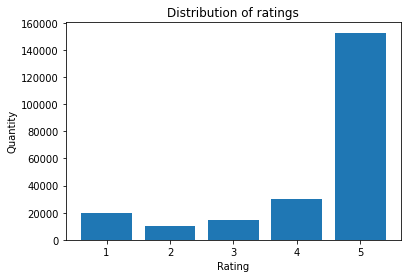

The count for 5 stars is 152651


In [409]:
# Would expect to see more good reviews as the word 'good' appears in 5x as many reviews as the word 'bad'
# Define axis
stars_x = np.array([1,2,3,4,5])
stars_y = np.array([])


# Extract counts
for i in stars_x:
    this_star_count = len(df.loc[df['score'] == i])
    stars_y = np.append(stars_y, this_star_count).astype('int32')
    

# Plot results
plt.bar(stars_x, stars_y)
plt.title('Distribution of ratings')
plt.xlabel('Rating')
plt.ylabel('Quantity')
plt.show()

chosen_index = 4
print('The count for', chosen_index + 1, 'stars is', stars_y[chosen_index])

##### Sample is heavily biased towards 5 star reviews, this will be adjusted prior to modelling

# Data Preparation

### Extract data and store in list

In [410]:
# Create empty list to append review objects
reviews = []


# Iterate through rows storing the score, summary and text in the Reviews class, storing the object in the empty list
for i, row in df.iterrows():
    reviews.append(Review(row['score'], row['text']))

### Split data into train/test samples

In [411]:
from sklearn.model_selection import train_test_split


# Split proportionally and randomly
train, test = train_test_split(reviews, test_size = 0.2, random_state = 42)


# Pass the train objects into the sample class so the score/summary/text can be extracted from the entire list
# rather than just from an indexed list value
train_samp = Samples(train)
test_samp = Samples(test)


train_samp.smooth_samples()
test_samp.smooth_samples()

### Define splits

In [412]:
# Define the summary training variables
train_x = train_samp.extract_text()
train_y = train_samp.extract_score()


# Define the summary testing variables
test_x = test_samp.extract_text()
test_y = test_samp.extract_score()

# Vectorisation (bag of words)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer


# Initialise the vectoriser
vectoriser = TfidfVectorizer(stop_words = 'english')


# Vectorise and scale training reviews and summaries
train_x_vect = vectoriser.fit_transform(train_x)


# Vectorise the testing reviews and summaries
# Only tansform so that the scaling parameters learned from the training samples can be applied
test_x_vect = vectoriser.transform(test_x)

# Classification

In [ ]:
# Import model, limited to svm and logistic regression as we are working with strings
from sklearn import svm
from sklearn.linear_model import LogisticRegression


# Initialise models
svm = svm.SVC()
lr = LogisticRegression()
lrgs = LogisticRegression(penalty = 'l2', C=10, solver = 'liblinear', max_iter = 500) # with grid search parameters


# logistic regression is used as trials with reduced sample sizes shows greater accuracy and shorter run time than svm

### Fit to the Logistic Regression model, prior to grid search

In [ ]:
lr.fit(train_x_vect, train_y)


print('Accuracy prior to grid seacrh', round(lr.score(test_x_vect, test_y)*100,2),'%')

### Fit to the LR model, with grid search parameters

In [ ]:
lrgs.fit(train_x_vect, train_y)


print('Accuracy prior to grid seacrh', round(lrgs.score(test_x_vect, test_y)*100,2),'%')

### F1 scores

In [ ]:
from sklearn.metrics import f1_score


f1_score(test_y, lrgs.predict(test_x_vect), average = None)

##### The accuracy is skewed towards the 5 star reviews. Further reducing the 5 star sample size, doesn't actually result in a meaningful improvement to this distribution when compared to the drop in overall accuracy. Thus the sample size of 5 star reviews is left larger than the others, but stil reduced significantly compared to the initial size

### Examples (modify index for different reviews)

In [ ]:
i = 90


print('The actual score is', test_y[i])
print('The predicted score (before grid search) is', lr.predict(test_x_vect[i])[0])
print('The predicted score (after grid search) is', lrgs.predict(test_x_vect[i])[0])

# Accuracy for +/- 1 star

### Create dataframe with integer score values

In [ ]:
# Define empty lists for appending data
actual_list = []
predicted_list = []


# Create tuple containing lists to be looped through
lists = zip(test_y, lrgs.predict(test_x_vect))


# Loop through lists to append data
for j, k in lists:
    actual_list.append(j)
    predicted_list.append(k)


# Create dataframe
data = {'predicted' : predicted_list,'actual' : actual_list}
pred_df = pd.DataFrame(data)

### Create 'in_range" collumn and assess accuracy

In [ ]:
# Create collumns containing integer values for predicted and actual scores
pred_df['predicted_as_integer'] = pred_df['predicted'].apply(lambda x: get_integer(x))
pred_df['actual_as_integer'] = pred_df['actual'].apply(lambda x: get_integer(x))


# Calculate the absolute difference between scores
pred_df['difference'] = abs(pred_df['actual_as_integer'] - pred_df['predicted_as_integer'])


# Calculate percentage accuracy
not_in_range = len(pred_df.loc[pred_df['difference'] > 1])
total = len(pred_df)
percentage = round(((total - not_in_range)/ total)*100,2)


print('Accuracy of prediction +/- 1 star is', percentage, '%')

### Final result prepartion

In [ ]:
acuracy_level = ['Exact score', 'Score +/- 1']
accuracy = [round(lrgs.score(test_x_vect, test_y)*100,2), percentage]
result_data = {'Precision Level' : acuracy_level, 'Accuracy' : accuracy}
df_results = pd.DataFrame(result_data).set_index('Precision Level')

# Final results

In [ ]:
df_results

### Grid search to improve accuracy

##### The code is commented out and moved to the back as it has a very long run time. The grid seach analysis was performed with a reduced sample size, with the optimal parameters output, thus is not needed in the final run.

In [ ]:
# Import models
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold


# Define grid parameters
#grid={'C':[0.01,0.1,10,100,1000], 'solver': ['newton-cg', 'lbfgs', 'liblinear'],
      #'penalty':['none','l1','l2','elasticnet']}


# Define cv splits
#cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)


# Search grid and fit training x and y
#clf=GridSearchCV(estimator=LogisticRegression(),param_grid=grid,cv=cv,n_jobs = 1,scoring='accuracy')
#result = clf.fit(train_x_vect,train_y)


# Print best result and parameters to be used
#print(result.best_score_)
#print(result.best_params_)